In [1]:
!nvidia-smi

Tue Mar  5 17:21:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [7]:
## Import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
ROOT_PATH = '/content/drive/MyDrive'

In [12]:
!pwd

/content


In [13]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive'

In [30]:
## re-size the images to this

IMAGE_SIZE =[224,224]
train_path = 'cat_dog_dataset/train'
valid_path = 'cat_dog_dataset/test'

In [31]:
# Impoer the VGG16 library as show below and add preprocessing layer to the front of VGG
# Here  we will be using imagenet weight
vgg16 = VGG16(input_shape =IMAGE_SIZE +[3], weights = 'imagenet',include_top=False)

In [32]:
# don't train existing weights
for layer in vgg16.layers:
  print(layer)

In [33]:
# dont't train existing weights
for layer in vgg16.layers:
  layer.trainable =False

In [34]:
for layer in vgg16.layers:
  print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [35]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
# useful for getting unmber of output classes
folders = glob('cat_dog_dataset/train/*')

In [37]:
folders

['cat_dog_dataset/train/cats', 'cat_dog_dataset/train/dogs']

In [38]:
len(folders)

2

In [39]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [40]:
# viwe Summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [41]:
# tell the model what cost and optimization method to use
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [44]:
# Use the Image data Generate to import the image from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range =0.2,
                                   zoom_range=0.2,
                                   horizontal_flip =True)
test_datagen = ImageDataGenerator(rescale= 1./225)

In [45]:
!pwd

/content/drive/MyDrive


In [48]:
# Make sure your provide the same target size as intialied for the image size
training_set = train_datagen.flow_from_directory('cat_dog_dataset/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 557 images belonging to 2 classes.


In [50]:
test_set = train_datagen.flow_from_directory('cat_dog_dataset/test',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 140 images belonging to 2 classes.


In [51]:
# fit the model
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs =15,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

Epoch 1/15
5/5 [==============================] - 79s 17s/step - loss: 6.2319 - accuracy: 0.4714 - val_loss: 3.1838 - val_accuracy: 0.5000
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 1.8743 - accuracy: 0.5143 - val_loss: 0.6100 - val_accuracy: 0.7071
Epoch 3/15
5/5 [==============================] - 7s 1s/step - loss: 0.6470 - accuracy: 0.6929 - val_loss: 0.3425 - val_accuracy: 0.8143
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 0.4058 - accuracy: 0.8071 - val_loss: 0.3043 - val_accuracy: 0.8571
Epoch 5/15
5/5 [==============================] - 7s 1s/step - loss: 0.2727 - accuracy: 0.8786 - val_loss: 0.3229 - val_accuracy: 0.8500
Epoch 6/15
5/5 [==============================] - 5s 1s/step - loss: 0.2796 - accuracy: 0.8643 - val_loss: 0.2595 - val_accuracy: 0.8929
Epoch 7/15
5/5 [==============================] - 7s 1s/step - loss: 0.1691 - accuracy: 0.9357 - val_loss: 0.1423 - val_accuracy: 0.9357
Epoch 8/15
5/5 [=======================

In [52]:
import matplotlib.pyplot as plt


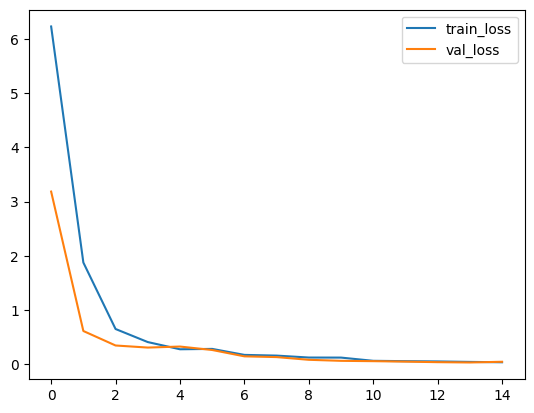

<Figure size 640x480 with 0 Axes>

In [56]:
# plot the loss
plt.plot(r.history['loss'], label = 'train_loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()
plt.savefig('lossVal_loss')

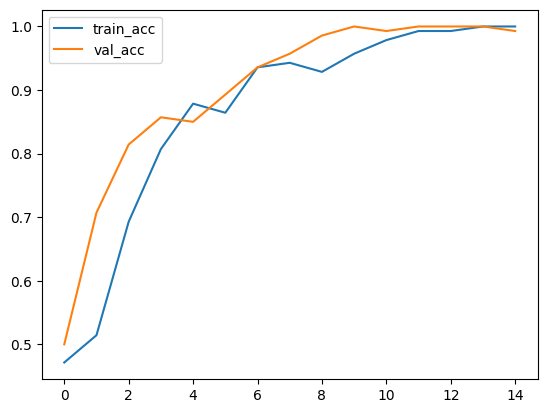

<Figure size 640x480 with 0 Axes>

In [57]:
# plot the loss
plt.plot(r.history['accuracy'], label = 'train_acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show()
plt.savefig('AccVal_loss')

In [58]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
y_pred = model.predict(test_set)

5/5 [==============================] - 3s 644ms/step


In [60]:
y_pred

array([[2.52275349e-05, 9.99974728e-01],
       [2.94607179e-03, 9.97053981e-01],
       [7.47543156e-01, 2.52456814e-01],
       [1.21443961e-02, 9.87855613e-01],
       [8.48580241e-01, 1.51419789e-01],
       [8.28957825e-04, 9.99171019e-01],
       [6.26802212e-03, 9.93731916e-01],
       [3.54799815e-03, 9.96451974e-01],
       [9.75095272e-01, 2.49047745e-02],
       [8.32295060e-01, 1.67704955e-01],
       [9.33272123e-01, 6.67278916e-02],
       [9.85993862e-01, 1.40061015e-02],
       [9.93135571e-01, 6.86446391e-03],
       [9.96476591e-01, 3.52341356e-03],
       [2.72802566e-03, 9.97271955e-01],
       [2.17438140e-03, 9.97825563e-01],
       [9.39967856e-02, 9.06003237e-01],
       [7.87140310e-01, 2.12859645e-01],
       [1.02938623e-06, 9.99998927e-01],
       [9.31463728e-04, 9.99068558e-01],
       [9.99786556e-01, 2.13493913e-04],
       [9.25961975e-03, 9.90740418e-01],
       [1.38751008e-02, 9.86124933e-01],
       [9.96065199e-01, 3.93481832e-03],
       [9.762443